# ************************************************************* #
#               Copyright (C) 2022 Jorge Brenes Alfaro.
#               EL5617 Trabajo Final de Graduación.
#               Escuela de Ingeniería Electrónica.
#               Tecnológico de Costa Rica.
# ************************************************************* #

This file is responsible for generating the mimetic neural network (MNN). First, the data collected from the PAHM is processed, which is reshaped as necessary for the network. Next, the model is developed using recurrent neural networks (RNN), specifically the GRU.

In [1]:
#Libraries to proccess data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Libraries to create RNAM
import tensorflow as tf
from sklearn.preprocessing import MaxAbsScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Dropout, GRU, TimeDistributed

import warnings
warnings.filterwarnings('ignore')

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: jorgebre98 (mimetic-rna). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="Prueba", 
           entity="mimetic-rna", 
           name='Probando tensorflow cpu5',
           resume='Allow', 
           id='Probando tensorflow cpu5')
wandb.config = {
    "epochs": 10,
    "batch_size": 1,
    "learning_rate":0.001,
    "window": 4,
    "Dropout": 0.35,
    "n_layers":1
}

 Process the Dataset 

In [3]:
def normalizer(angle):
    norm = MaxAbsScaler()
    angle_normalizer = norm.fit_transform(angle)
    return angle_normalizer

In [4]:
# For each element of training set, we have "window" previous training set elements
def window_generator(train, target, window):
    X_train = []
    Y_train = []
    
    for i in range(window,train.shape[0]):
        X_train.append(train[i-window:i])
        Y_train.append(target[i])
        
    X_train, Y_train = np.array(X_train), np.array(Y_train) # Input and output arrays
    Y_train = np.reshape(Y_train,(Y_train.shape[0],1))
    Y_train = normalizer(Y_train)
    return X_train,Y_train

In [5]:
# Separate the values in train, validation and test data/label
def separate_values(X_train, Y_train):
    train_data, val_data, test_data = [],[],[]
    train_label, val_label, test_label = [],[],[]
    train_lenght = int(len(X_train)*3/5)
    val_lenght = int(len(X_train)*4/5)
    
    # Use 3/5 of the total data set for training
    # and 1/5 for validation and testing.
    for i,j in zip(X_train[:train_lenght],Y_train[:train_lenght]):
        train_data.append(i)
        train_label.append(j)
    print(len(train_label))
    
    for i,j in zip(X_train[train_lenght:val_lenght],Y_train[train_lenght:val_lenght]):
        val_data.append(i)
        val_label.append(j)
    
    for i,j in zip(X_train[val_lenght:],Y_train[val_lenght:]):
        test_data.append(i)
        test_label.append(j)
    
    train_data, val_data, test_data = np.array(train_data), np.array(val_data), np.array(test_data)
    train_label, val_label, test_label = np.array(train_label), np.array(val_label), np.array(test_label)
        
    return train_data, train_label, val_data, val_label, test_data, test_label

In [6]:
# Reshape the arrays (n,window,1). Where n is the total amount of data in the array
def GRU_tensor(train_data, train_label, val_data, val_label, test_data, test_label):
    train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1],1))
    val_data = np.reshape(val_data,(val_data.shape[0],val_data.shape[1],1))
    test_data = np.reshape(test_data,(test_data.shape[0],test_data.shape[1],1))

    train_label = np.reshape(train_label, (train_label.shape[0]))
    val_label = np.reshape(val_label, (val_label.shape[0]))
    test_label = np.reshape(test_label, (test_label.shape[0]))
    
    return train_data, train_label, val_data, val_label, test_data, test_label

In [7]:
root = '/Users/jorge/Documents/TEC/TFG/Datos_Recolectados/'
Dir = os.listdir(root)
pwm = np.array([])
angle = np.array([])

# Read all the .csv files and make an nx4 array
# Next, separate the pwm value and angle in their respective arrays.
print('******************* Process the Dataset *******************',flush=True)
print('Recolecting Data',flush=True)
for filename in Dir:
    files = pd.read_csv(root+filename)
    pwm = np.append(pwm, np.concatenate((np.zeros(100),files.values[:,2])))
    angle = np.append(angle, np.concatenate((np.zeros(100),files.values[:,3])))

print('Accommodating data for the GRU network',flush=True)
window = wandb.config['window']
train, target = window_generator(pwm,angle,wandb.config['window'])

print('Separating data in training, validation and testing',flush=True)
train_data, train_label, val_data, val_label, test_data, test_label = separate_values(train, target)

print('Total train data is: ', len(train_data), flush=True)
print('Total validation data is: ', len(val_data), flush=True)
print('Total testing data is:: ', len(test_data), flush=True)

print('Reshape arrays to tensors',flush=True)
train_X, train_target, val_X, val_target, test_X, test_target = GRU_tensor(train_data, train_label,
                                                                           val_data, val_label,
                                                                           test_data, test_label)
print('\nTrain data shape is: ', train_X.shape, flush=True)
print('Validation data shape is: ', val_X.shape, flush=True)
print('Testing data shape is:: ', test_X.shape, flush=True)
print('Train label shape is: ', train_target.shape, flush=True)
print('Validation label shape is: ', val_target.shape, flush=True)
print('Testing label shape is:: ', test_target.shape, flush=True)

print('******************* Finish *******************',flush=True)

******************* Process the Dataset *******************
Recolecting Data
Accommodating data for the GRU network
Separating data in training, validation and testing
82969
Total train data is:  82969
Total validation data is:  27656
Total testing data is::  27657
Reshape arrays to tensors

Train data shape is:  (82969, 4, 1)
Validation data shape is:  (27656, 4, 1)
Testing data shape is::  (27657, 4, 1)
Train label shape is:  (82969,)
Validation label shape is:  (27656,)
Testing label shape is::  (27657,)
******************* Finish *******************


******************* Neural Network *******************

Model creation

In [8]:
clear_session()

model = Sequential()
model.add(GRU(units=4, input_shape=(train_X.shape[1],train_X.shape[2]), return_sequences=True, time_major=True))
#model.add(Dropout(wandb.config['Dropout'])
#model.add(Dense(units=1))
model.add(TimeDistributed(Dense(1))) # There is no difference between this and model.add(Dense(1))...
model.compile(optimizer=Adam(learning_rate=wandb.config['learning_rate']), loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4, 4)              84        
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 1)              5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


Model Training

In [9]:
history = model.fit(train_X, train_target,
                    epochs=wandb.config['epochs'], batch_size=wandb.config['batch_size'],
                    validation_data = (val_X,val_target),
                    verbose=2,callbacks=[WandbCallback(save_model=False)])

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/10
82969/82969 - 182s - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 2/10
82969/82969 - 186s - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 3/10
82969/82969 - 113s - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 4/10
82969/82969 - 86s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 5/10
82969/82969 - 87s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 6/10
82969/82969 - 88s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7/10
82969/82969 - 84s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 8/10
82969/82969 - 86s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 9/10
82969/82969 - 84s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 10/10
82969/82969 - 84s - loss: 0.0284 - mse: 0

In [10]:
# Prediction
testPredict = model.predict(test_X)

In [24]:
np.reshape(testPredict,(-1,1))

array([[ 0.19249626],
       [ 0.19249626],
       [ 0.19249626],
       ...,
       [-0.15550753],
       [-0.15550753],
       [-0.15550753]], dtype=float32)

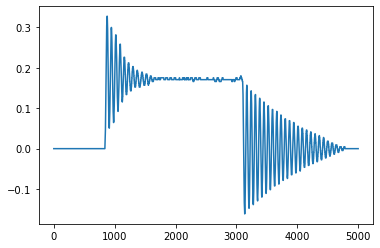

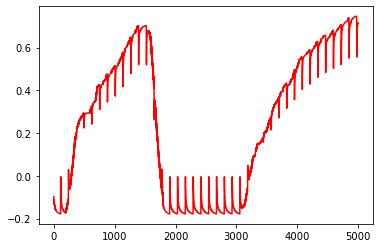

In [25]:
plt.figure()
plt.plot(np.reshape(test_target,-1)[10000:15000],label='Real Ouput')
plt.figure()
plt.plot(np.reshape(testPredict,-1)[10000:15000],'r',label='Predict Output')

Model Evaluate

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig('lossLSTM32.png')
plt.show()